In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('bank.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Pre-processing
1. Convert categorical data into numerical
2. Remove 'duration' and 'day' column
3. Shuffle the data
4. Normalize the data

Convert categorical data into numerical


In [ ]:
def categorical_to_numerical(df, col):
  df = pd.get_dummies(data=df, columns=col)
  return df

# drop_first encoded category to prevent multicollinearity
def categorical_to_numerical_drop_first(df, col):
  df = pd.get_dummies(data=df, columns=col, drop_first=True)
  return df

In [ ]:
df = categorical_to_numerical(df, ['marital', 'job', 'education', 'contact', 'month', 'poutcome'])
df = categorical_to_numerical_drop_first(df, ['housing', 'loan', 'deposit', 'default'])

Remove 'duration' and 'day' column

In [ ]:
df.drop(['duration', 'day'], axis=1, inplace=True)

Shuffle the data

In [ ]:
df = df.sample(frac=1, random_state=3)

Normalizing data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

min_max_data = minmax.fit_transform(df.drop('deposit_yes', axis=1))
x = pd.DataFrame(min_max_data, columns=df.columns.drop('deposit_yes'))

Splitting the data to train and test

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, df['deposit_yes'], test_size=0.25)

Building the Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

RandomForestClassifier()

Testing the model and accuracy

In [ ]:
y_cap = classifier.predict(x_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_cap)

print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 70.80%


Understanding feature importance using SHAP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.0 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


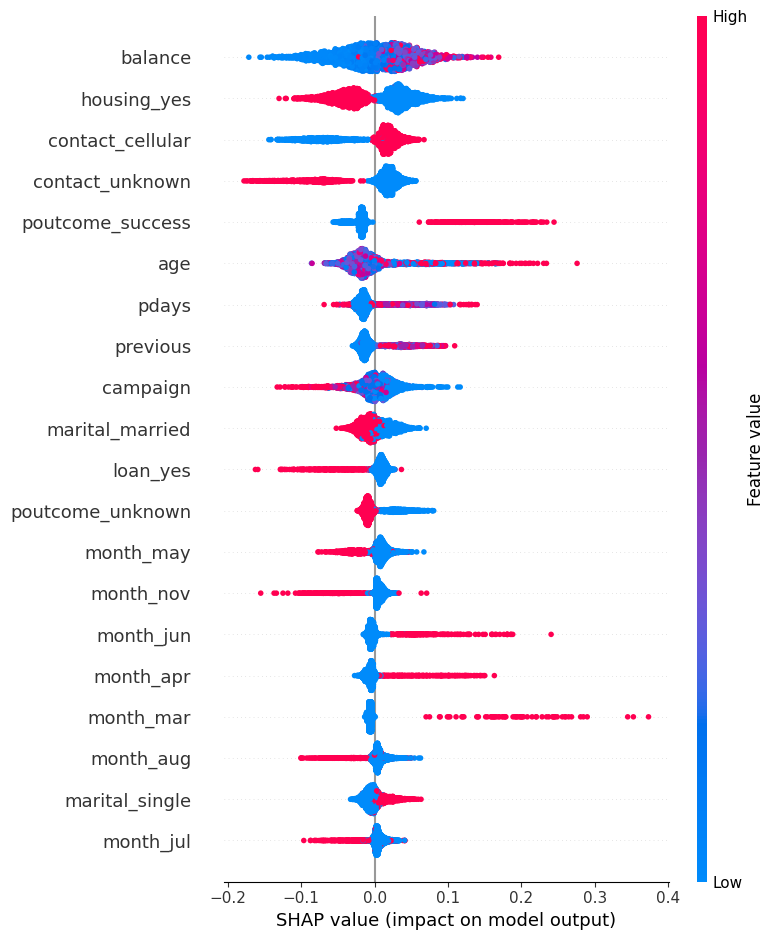

In [ ]:
!pip install shap
import shap
shap.initjs()

explainer = shap.Explainer(classifier)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values[1], x_test)

## A/B Testing

In [ ]:
df['group'] = np.nan

for index, row in df.iterrows():
  if row['age']>75 or row['age']<25 or row['balance']>df['balance'].mean():
    df['group'].iloc[index] = 'test'
  else:
    df['group'].iloc[index] = 'control'


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = df[df['group'] == 'control']['deposit_yes']
treatment_resuts = df[df['group'] == 'test']['deposit_yes']
num_control = control_results.count()

num_treatment = treatment_resuts.count()
successes = [control_results.sum(), treatment_resuts.sum()]
nobs = [num_control, num_treatment]

z_stat, pval = proportions_ztest(successes, nobs = nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'P-Value {pval:.3f}')

P-Value 0.574
